# Try a non-linear probe (few layer NN)

In [1]:
from pathlib import Path
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import pandas as pd

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from scripts.read_nh_results import (read_multi_experiment_results, calculate_member_errors)
from neuralhydrology.utils.config import Config

%load_ext autoreload
%autoreload 2

# create the model

In [2]:
from torch import nn
from typing import (List, Dict, Tuple)
import torch


from scripts.cell_state.cell_state_model import NonLinearModel, LinearModel

In [3]:
# hidden_sizes = [32, 5, 1]
# hs_str = "_".join([str(hs) for hs in hidden_sizes])
# activation = "relu"

# model = NonLinearModel(
#     input_size=64, 
#     hidden_sizes=hidden_sizes,
#     activation=activation
# )

device = "cuda:0"
D_in = 64

model = LinearModel(D_in=D_in)
model.to(device)

LinearModel(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
)

# Get the data

### Get the cell state data

In [4]:
from scripts.cell_state.extract_cell_state import get_cell_states
from scripts.cell_state.normalize import (normalize_xarray_cstate, normalize_xr_by_basin)


data_dir = Path("/datadrive/data/")

if not (data_dir / "SOIL_MOISTURE/norm_cs_data.nc").exists():
    out_dir = run_dir / "cell_states"
    if not out_dir.exists():
        out_dir.mkdir(parents=True, exist_ok=True)

    if not (out_dir / "cell_states.nc").exists():
        cn = get_cell_states(cfg, run_dir)
        cn.to_netcdf(out_dir / "cell_states.nc")
    else:
        cn = xr.open_dataset(out_dir / "cell_states.nc")

    cs_data = cn.copy()
    norm_cs_data = normalize_xarray_cstate(cs_data, cell_state_var="c_n")

    norm_cs_data["station_id"] = [int(sid) for sid in norm_cs_data["station_id"]]
    if "date" in norm_cs_data.dims:
        norm_cs_data = norm_cs_data.rename({"date": "time"})
else:
    norm_cs_data = xr.open_dataset(data_dir / "SOIL_MOISTURE/norm_cs_data.nc")

In [5]:
from scripts.cell_state.cell_state_dataset import dataset_dimensions_to_variable

cs = dataset_dimensions_to_variable(norm_cs_data)
cs

<xarray.Dataset>
Dimensions:     (station_id: 669, time: 4018)
Coordinates:
  * time        (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2008-12-31
  * station_id  (station_id) int64 10002 10003 1001 101002 ... 96002 96004 97002
Data variables: (12/64)
    dim0        (time, station_id) float32 0.501 0.5307 ... -1.728 -0.9923
    dim1        (time, station_id) float32 -0.1513 -0.6046 ... 0.3006 0.09346
    dim2        (time, station_id) float32 -0.6372 -0.7133 ... 0.5675 0.4924
    dim3        (time, station_id) float32 0.6287 0.831 ... -0.7018 -0.2735
    dim4        (time, station_id) float32 -0.6776 -0.8042 ... 0.4647 -0.0174
    dim5        (time, station_id) float32 -0.3366 -0.9239 ... 1.232 1.192
    ...          ...
    dim58       (time, station_id) float32 -0.7734 -1.206 ... 0.2728 0.8116
    dim59       (time, station_id) float32 -0.4587 0.1375 ... -0.8789 -1.718
    dim60       (time, station_id) float32 0.1834 0.7419 ... -1.303 -0.8052
    dim61       (time, station_id) float32 -0.524 2.19 1.108 ... -0.07036 0.6145
    dim62       (time, station_id) float32 -2.113 -1.317 ... -0.08194 -0.3814
    dim63       (time, station_id) float32 1.405 0.6013 ... -1.188 -0.09205

### normalised ESA CCI SM

In [36]:
%load_ext autoreload 
%autoreload 2
from scripts.cell_state.analysis import finite_flat, histogram_plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
from scripts.cell_state.cell_state_dataset import fill_gaps
from scripts.cell_state.normalize import normalize_2d_dataset

fill = "interpolate"

# soil moisture data
processed_filepath = data_dir / "SOIL_MOISTURE/interp_norm_esa_cci_sm.nc"
if not processed_filepath.exists():
    # load in esa cci [basin chopped]
    esa_ds = xr.open_dataset(data_dir / "camels_basin_ESACCI_sm.nc")    
    esa_ds["station_id"] = esa_ds.station_id.astype("int64")
    esa_ds = esa_ds.sortby("time")
    
    # interpolate esa sm data [fill gaps]
    esa_ds = fill_gaps(esa_ds, fill=fill)
    
    # normalise sm data [normalize by basin]
    norm_sm = normalize_2d_dataset(esa_ds)
    norm_sm["station_id"] = [int(sid) for sid in norm_sm["station_id"]]

    # save to disk
    norm_sm.to_netcdf(processed_filepath)

else:
    norm_sm = xr.open_dataset(processed_filepath)

In [38]:
# Load the discharge data to be the 
ds = xr.open_dataset("/home/tommy/spatio_temporal/data/ALL_dynamic_ds.nc")

ds["discharge_spec"]

<xarray.DataArray 'discharge_spec' (time: 16436, station_id: 671)>
[11028556 values with dtype=float64]
Coordinates:
  * station_id  (station_id) int64 1001 2001 2002 3003 ... 102001 106001 107001
  * time        (time) datetime64[ns] 1970-10-01 1970-10-02 ... 2015-09-30

In [39]:
epsilon = 1e-10
log_q = np.log(ds["discharge_spec"] + epsilon)

norm_log_q = normalize_2d_dataset(log_q.to_dataset(), variable_str="discharge_spec")

Normalising each station: 100%|██████████| 671/671 [00:00<00:00, 678.41it/s]


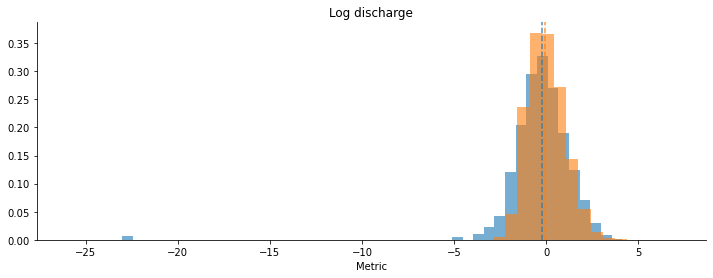

In [41]:
ax = histogram_plot(finite_flat(log_q.values), hist_kwargs={"color": "C0", "label": "Log Only"})
histogram_plot(finite_flat(norm_log_q.values), ax=ax, hist_kwargs={"color": "C1", "label": "Log-Normed"})

ax.set_title("Log discharge");

# DataLoader

In [13]:
from scripts.cell_state.timeseries_dataset import get_train_test_dataloader

train_start_date = pd.to_datetime("01-01-1998")
train_end_date = pd.to_datetime("12-31-2006")
test_start_date = pd.to_datetime("01-01-2007")
test_end_date = pd.to_datetime("01-01-2009")

batch_size = 256
train_dl, test_dl = get_train_test_dataloader(
    input_data=cs,
    target_data=log_q,
    target_variable="discharge_spec",
    input_variables=[v for v in cs.data_vars],
    seq_length=1,
    basin_dim="station_id",
    time_dim="time",
    batch_size=batch_size,
    train_start_date=train_start_date,
    train_end_date=train_end_date,
    test_start_date=test_start_date,
    test_end_date=test_end_date,
    num_workers=4,
)

Creating Test Samples: 100%|██████████| 669/669 [00:04<00:00, 136.15it/s]


# Train model

In [14]:
from scripts.cell_state.timeseries_model import train, predict

In [15]:
device = "cuda:0"

model.to(device)
losses = train(
    model=model,
    dataloader=train_dl,
    device=device,
    n_epochs=10
)

Training Model Epoch 9: 100%|██████████| 8441/8441 [00:31<00:00, 269.37it/s, 24.24773]  


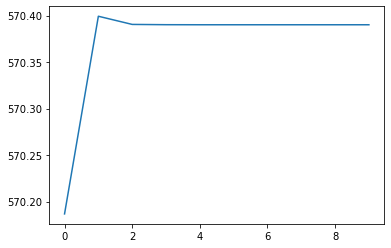

In [16]:
plt.plot(losses)

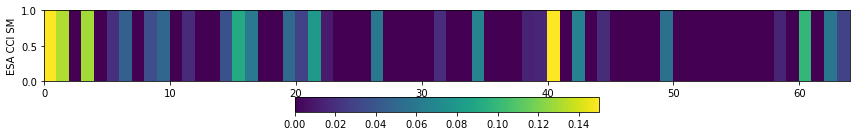

In [18]:
ws, bs = [p.detach().cpu().numpy() for p in model.parameters()]

# weights = ws
f, ax = plt.subplots(figsize=(12, 2))
im = ax.pcolormesh(ws, vmin=0, vmax=0.15)
ax.set_ylabel(f"ESA CCI SM")

plt.colorbar(im, orientation='horizontal')
plt.tight_layout()

# Make predictions

In [19]:
#  PREDICT
preds = predict(model=model, dataloader=test_dl, device=device)

#  EVALUATE with error metrics
errors = calculate_all_error_metrics(
    preds,
    basin_coord="station_id",
    time_coord="time",
    obs_var="y",
    sim_var="y_hat",
    metrics=["NSE", "Pearson-r"],
)

preds.to_netcdf(data_dir / f"SOIL_MOISTURE/results/discharge_linear_probe_preds.nc")

Calculating Errors: 100%|██████████| 665/665 [00:07<00:00, 84.83it/s, 107001]


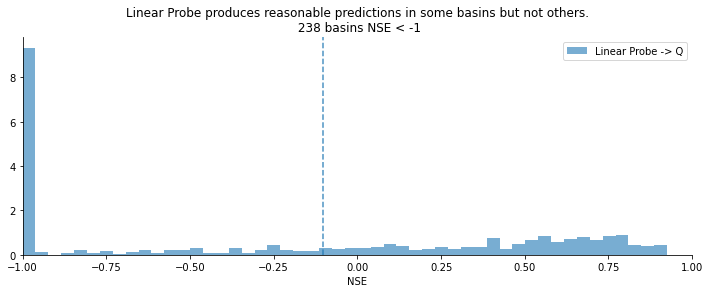

In [22]:
variable = "Pearson-r"
variable = "NSE"


n_negative = int((finite_flat(errors[variable].values) < -1).sum())
f, ax = plt.subplots(figsize=(12, 4))
if variable == "NSE":
#     histogram_plot(arr=np.clip(isfinite_flat(precip_errors[variable].values), -1, 1), ax=ax, hist_kwargs={"color": "C2", "label": "Precip Linear Probe"})
#     histogram_plot(arr=np.clip(isfinite_flat(control_errors[variable].values), -1, 1), ax=ax, hist_kwargs={"color": "C1", "label": "Linear Probe"})
    histogram_plot(arr=np.clip(finite_flat(errors[variable].values), -1, 1), ax=ax, hist_kwargs={"color": "C0", "label": "Linear Probe -> Q"})

else:
#     histogram_plot(arr=isfinite_flat(precip_errors[variable].values), ax=ax, hist_kwargs={"color": "C2", "label": "Precip Linear Probe"})
#     histogram_plot(arr=isfinite_flat(control_errors[variable].values), ax=ax, hist_kwargs={"color": "C1", "label": "Linear Probe"})
    histogram_plot(arr=finite_flat(errors[variable].values), ax=ax, hist_kwargs={"color": "C0", "label": "Linear Probe -> Q"})

ax.set_xlim(-1, 1)
ax.set_xlabel(variable)
ax.set_title(f"Linear Probe produces reasonable predictions in some basins but not others.\n {n_negative} basins NSE < -1")
ax.legend();

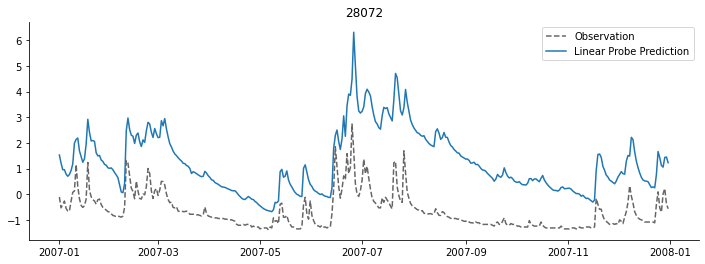

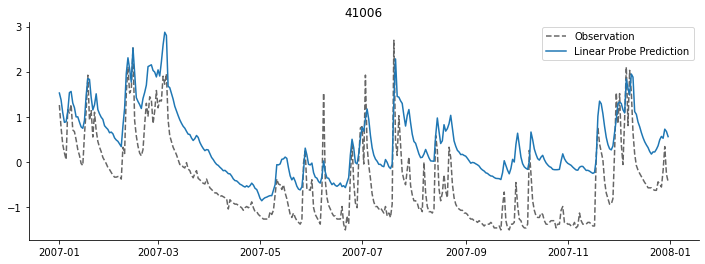

In [24]:
choices = np.random.choice(preds.station_id.values, 2)

for px in choices:
    f, ax = plt.subplots(figsize=(12, 4))
    data = preds.sel(station_id=px, time="2007").to_dataframe()
    ax.plot(data.index, data["y"], color="k", alpha=0.6, ls="--", label="Observation")
    ax.plot(data.index, data["y_hat"], label=f"Linear Probe Prediction")
    ax.set_title(px)
    ax.legend()
    sns.despine()

# Non linear model

In [ ]:
device = "cuda:0"
hidden_sizes = [32, 5, 1]
hs_str = "_".join([str(hs) for hs in hidden_sizes])
activation = "relu"

nl_model = NonLinearModel(
    input_size=64, 
    hidden_sizes=hidden_sizes,
    activation=activation
)

nl_model.to(device)
losses = train(
    model=nl_model,
    dataloader=train_dl,
    device=device,
    n_epochs=10
)

In [ ]:
#  PREDICT
nl_preds = predict(model=nl_model, dataloader=test_dl, device=device)

#  EVALUATE with error metrics
nl_errors = calculate_all_error_metrics(
    nl_preds,
    basin_coord="station_id",
    time_coord="time",
    obs_var="y",
    sim_var="y_hat",
    metrics=["NSE", "Pearson-r"],
)

nl_preds.to_netcdf(data_dir / f"SOIL_MOISTURE/results/discharge_NONlinear_probe_preds.nc")

# compare non linear model vs. 

In [ ]:
choices = np.random.choice(preds.station_id.values, 2)

for px in choices:
    f, ax = plt.subplots(figsize=(12, 4))
    data = preds.sel(station_id=px, time="2007").to_dataframe()
    nl_data = nl_preds.sel(station_id=px, time="2007").to_dataframe()
    ax.plot(data.index, data["y"], color="k", alpha=0.6, ls="--", label="Observation")
    ax.plot(data.index, data["y_hat"], label=f"Linear Probe Prediction")
    ax.plot(nl_data.index, nl_data["y_hat"], label=f"NonLinear Probe Prediction")
    
    ax.legend()
    sns.despine()

# Compare all of the probes

In [ ]:
nl_sm_errors = xr.open_dataset(data_dir / f"SOIL_MOISTURE/results/non_linear_probe_control_32_5_1_relu.nc")
sm_errors = xr.open_dataset(data_dir / "SOIL_MOISTURE/results/linear_probe_control.nc")

In [ ]:
f, ax = plt.subplots(figsize=(12, 4))
variable = "NSE"

histogram_plot(
    arr=np.clip(isfinite_flat(errors[variable].values), -1, 1), 
    ax=ax, 
    hist_kwargs={"color": "C2", "label": "Linear Probe -> Q"}
)
histogram_plot(
    arr=np.clip(isfinite_flat(nl_errors[variable].values), -1, 1), 
    ax=ax, 
    hist_kwargs={"color": "C3", "label": "Non Linear Probe -> Q"}
)
histogram_plot(
    arr=np.clip(isfinite_flat(sm_errors[variable].values), -1, 1), 
    ax=ax, 
    hist_kwargs={"color": "C0", "label": "Linear Probe -> SM"}
)

histogram_plot(
    arr=np.clip(isfinite_flat(nl_sm_errors[variable].values), -1, 1), 
    ax=ax, 
    hist_kwargs={"color": "C1", "label": "Non Linear Probe -> SM"}
)
ax.set_xlabel(variable)
ax.legend();

# ElasticNet Sklearn model

In [28]:
from scripts.cell_state.timeseries_dataset import get_data_samples, get_time_basin_aligned_samples, TimeSeriesDataset

In [29]:
input_variables = [v for v in cs.data_vars]

In [42]:
train_dataset = TimeSeriesDataset(
    input_data=cs.sel(time=slice(train_start_date, train_end_date)),
    target_data=norm_log_q.sel(time=slice(train_start_date, train_end_date)),
    target_variable="discharge_spec",
    input_variables=input_variables,
    seq_length=1,
    basin_dim="station_id",
    time_dim="time",
    desc="Creating Train Samples",
)

test_dataset = TimeSeriesDataset(
    input_data=cs.sel(time=slice(test_start_date, test_end_date)),
    target_data=norm_log_q.sel(time=slice(test_start_date, test_end_date)),
    target_variable="discharge_spec",
    input_variables=input_variables,
    seq_length=1,
    basin_dim="station_id",
    time_dim="time",
    desc="Creating Test Samples",
)

Creating Test Samples: 100%|██████████| 669/669 [00:04<00:00, 135.66it/s]


In [43]:
X, y, times, station_ids = get_time_basin_aligned_samples(train_dataset)
X_test, y_test, times_test, station_ids_test = get_time_basin_aligned_samples(test_dataset)

Extracting Data:   0%|          | 0/1887 [00:00<?, ?it/s]

Merging and reshaping arrays


Extracting Data: 100%|██████████| 1887/1887 [00:13<00:00, 144.65it/s]


Merging and reshaping arrays


In [44]:
from sklearn.linear_model import SGDRegressor


sgd_en = SGDRegressor(
    loss="huber",
    penalty="elasticnet",
    alpha=0.01,
    l1_ratio=0.15,            # default
    fit_intercept=True, 
    n_iter_no_change=10,
    early_stopping=True
)

## fit and predict

In [45]:
sgd_en.fit(X, y.ravel())

SGDRegressor(alpha=0.01, early_stopping=True, loss='huber', n_iter_no_change=10,
             penalty='elasticnet')

In [46]:
y_hat = sgd_en.predict(X_test)

## calculate predictions and errors

In [47]:
preds_sklearn = pd.DataFrame({
    "station_id": station_ids_test.ravel(),
    "time": times_test.astype("datetime64[ns]").ravel(),
    "obs": y_test.ravel(),
    "sim": y_hat.ravel(),
}).set_index(["station_id", "time"]).to_xarray()

In [48]:
y_hat_train = sgd_en.predict(X)
print("Made Predictions")

train_preds = pd.DataFrame({
    "station_id": station_ids.ravel(),
    "time": times.astype("datetime64[ns]").ravel(),
    "obs": y.ravel(),
    "sim": y_hat_train.ravel(),
}).set_index(["station_id", "time"]).to_xarray()

Made Predictions


In [49]:
from scripts.read_nh_results import calculate_all_error_metrics

errors_sklearn = calculate_all_error_metrics(
    preds_sklearn,
    basin_coord="station_id",
    time_coord="time",
    obs_var="obs",
    sim_var="sim",
    metrics=["NSE", "Pearson-r"],
)

train_errors_sklearn = calculate_all_error_metrics(
    train_preds,
    basin_coord="station_id",
    time_coord="time",
    obs_var="obs",
    sim_var="sim",
    metrics=["NSE", "Pearson-r"],
)

Calculating Errors: 100%|██████████| 666/666 [00:10<00:00, 64.03it/s, 107001]


In [61]:
sm_errors = xr.open_dataset(data_dir / "SOIL_MOISTURE/results/sm_sklearn_probe_errors.nc")
sm_preds = xr.open_dataset(data_dir / "SOIL_MOISTURE/results/sm_sklearn_probe_preds.nc")

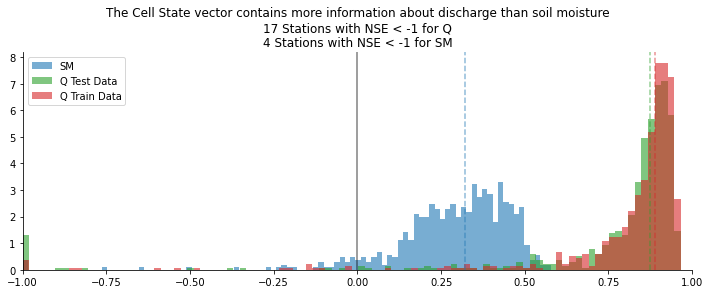

In [56]:
nse = finite_flat(errors_sklearn["NSE"])
nse_train = finite_flat(train_errors_sklearn["NSE"])
sm_nse = finite_flat(sm_errors["NSE"])

f, ax = plt.subplots(figsize=(12, 4))

ax.hist(sm_nse.where(sm_nse > -1, -1), bins=100, density=True, label="SM", alpha=0.6, color="C0");
ax.axvline(sm_nse.median(), color="C0", ls="--", alpha=0.5)

ax.hist(nse.where(nse > -1, -1), bins=100, density=True, label="Q Test Data", alpha=0.6, color="C2");
ax.axvline(nse.median(), color="C2", ls="--", alpha=0.5)

ax.hist(nse_train.where(nse_train > -1, -1), bins=100, density=True, label="Q Train Data", alpha=0.6, color="C3");
ax.axvline(nse_train.median(), color="C3", ls="--", alpha=0.5)

ax.axvline(0, color="k", ls="-", alpha=0.5)
ax.set_title(f"The Cell State vector contains more information about discharge than soil moisture\n{int((nse < -1).sum())} Stations with NSE < -1 for Q\n{int((sm_nse < -1).sum())} Stations with NSE < -1 for SM")
ax.set_xlim(-1, 1)
ax.legend()
sns.despine()

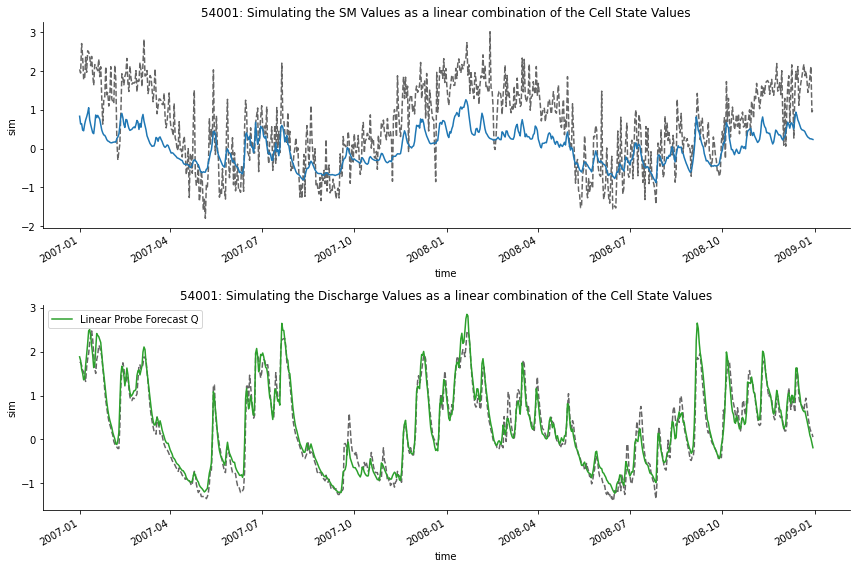

In [64]:
px = np.random.choice(preds_sklearn.station_id.values)
times = slice("2007", "2008")
f, axs = plt.subplots(2, 1, figsize=(12, 4*2))

ax = axs[0]
sm_preds.sel(station_id=px)["obs"].sel(time=times).plot(ax=ax, color="k", alpha=0.6, ls="--")
sm_preds.sel(station_id=px)["sim"].sel(time=times).plot(ax=ax, label="Linear Probe Forecast Q", color="C0")
ax.set_title(f"{px}: Simulating the SM Values as a linear combination of the Cell State Values")


ax = axs[1]
preds_sklearn.sel(station_id=px)["obs"].sel(time=times).plot(ax=ax, color="k", alpha=0.6, ls="--")
preds_sklearn.sel(station_id=px)["sim"].sel(time=times).plot(ax=ax, label="Linear Probe Forecast Q", color="C2")
ax.set_title(f"{px}: Simulating the Discharge Values as a linear combination of the Cell State Values")

plt.tight_layout()
plt.legend()
sns.despine()
